In [1]:
import os 
import glob
import numpy as np 
from PIL import Image
import matplotlib.pyplot as plt 

import tensorflow as tf

from tensorflow.keras.layers import (Dense,
                                     Reshape,
                                     Conv2DTranspose
                                     ,Conv2D,
                                     BatchNormalization,
                                     LeakyReLU,
                                     Input,
                                     Dropout,
                                     Flatten)

from tensorflow.keras.models import Model
from tqdm import tqdm

In [2]:
tf.__version__

'2.4.1'

In [66]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

C:\Users\bagat\anaconda3\lib\site-packages\tensorflow\python\client\session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [118]:
DATA_PATH = "C:\\Users\\bagat\\Desktop\\datasets\\faceceleb\\img_align_celeba\\img_align_celeba\\*jpg"
H,W,C = 28,28,1
LATENT_DIM = 100
INPUT_SHAPE = (H,W,C)
EPOCHS = 30000
BATCH_SIZE = 64
SAMPLE_PERIOD = 200

In [119]:
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.mnist.load_data()

In [120]:
# x_train = [np.array(Image.open(i).crop(CROP_FACE).resize((H,W)))/255 for i in tqdm(all_images_path)]

In [121]:
x_train = np.array(x_train)
x_train.shape

(60000, 28, 28)

In [122]:
x_train = (x_train-127.5) / 127.5

In [123]:
x_train[0][:2,:2] # 0-1 normalizde

array([[-1., -1.],
       [-1., -1.]])

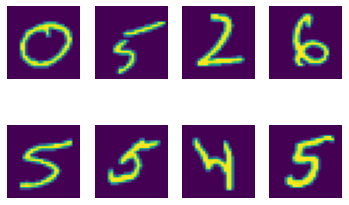

In [124]:
rows = 2 
cols = 4
fig,axs = plt.subplots(rows,cols)
for i in range(rows):
    for j in range(cols):
        idx = np.random.randint(0,x_train.shape[0])
        axs[i,j].imshow(x_train[idx])
        axs[i,j].axis("off")

## Transpose Conv Nedir?

In [125]:
def build_generator(latent_dim):
    inputx = Input(shape=(latent_dim,))
    x = Dense(7*7*256)(inputx)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Reshape([7,7,256])(x)
    x = Conv2DTranspose(128,5,strides=1,padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(1,5,strides=2,padding="same",activation="tanh")(x)
    model = Model(inputx,x)
    return model

    

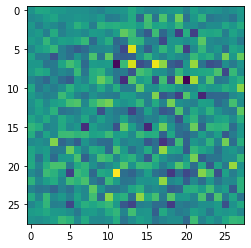

In [126]:
generator_model = build_generator(LATENT_DIM)
noise = np.random.randn(1,LATENT_DIM)
fake_img = generator_model.predict(noise)
plt.imshow(fake_img[0,:,:,0])

In [127]:
def build_discriminator(input_shape):
    inputx = Input(shape=input_shape)
    x = Conv2D(64,(5,5),strides=(2,2),padding="same")(inputx)
    x = LeakyReLU()(x)
    x = Dropout(.3)(x)
    x = Conv2D(128,(5,5),strides=(2,2),padding="same")(x)
    x = LeakyReLU()(x)
    x = Dropout(.3)(x)
    x = Flatten()(x)
    x = Dense(1,activation="sigmoid")(x)
    
    model = Model(inputx,x)
    return model

In [128]:
disc_model = build_discriminator(INPUT_SHAPE)
disc_model.summary()

Model: "model_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_50 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_51 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 7, 7, 128)         0  

## Combined Model

In [132]:
generator_model = build_generator(LATENT_DIM)
disc_model = build_discriminator(INPUT_SHAPE)
disc_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),loss="binary_crossentropy",metrics=["accuracy"])

inputs = Input(shape=(LATENT_DIM,))
img = generator_model(inputs)
disc_model.trainable=False
pred = disc_model(img)

combined_model = Model(inputs,pred)
combined_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),loss="binary_crossentropy")

combined_model.summary()

Model: "model_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_40 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
model_36 (Functional)        (None, 28, 28, 1)         2343681   
_________________________________________________________________
model_37 (Functional)        (None, 1)                 212865    
Total params: 2,556,546
Trainable params: 2,318,209
Non-trainable params: 238,337
_________________________________________________________________


In [133]:
d_losses = list()
g_losses = list()

ones = np.ones(BATCH_SIZE)
zeros = np.zeros(BATCH_SIZE)

In [134]:
def save_sample(epoch):
    rows,cols = 4,4
    noise = np.random.randn(rows*cols,LATENT_DIM)
    imgs = generator_model.predict(noise)

    fig,axs = plt.subplots(rows,cols)
    ids = 0 
    for i in range(rows):
        for j in range(cols):
            axs[i,j].imshow(imgs[ids][:,:,0]*127.5+127.5,cmap="gray")
            axs[i,j].axis("off")
            ids +=1

    fig.savefig(f"C:\\Users\\bagat\\Desktop\\Projects\\GAN\\generated\\{epoch}.png")
    plt.close()

In [136]:

for epoch in range(EPOCHS):
    ids = np.random.randint(0,x_train.shape[0],BATCH_SIZE)
    real_imgs = x_train[ids]

    noise = np.random.randn(BATCH_SIZE,LATENT_DIM)
    fake_imgs = generator_model(noise)

    d_loss_real , d_acc_real = disc_model.train_on_batch(real_imgs,ones)
    d_loss_fake , d_acc_fake = disc_model.train_on_batch(fake_imgs,zeros)

    
    d_loss = (d_loss_real+d_loss_fake)/2
    d_acc = (d_acc_real+d_acc_fake)/2

    noise = np.random.randn(BATCH_SIZE,LATENT_DIM)
    g_loss = combined_model.train_on_batch(noise,ones)

    noise = np.random.randn(BATCH_SIZE,LATENT_DIM)
    g_loss = combined_model.train_on_batch(noise,ones)

    d_losses.append(d_loss)
    g_losses.append(g_loss)

    if epoch%100 == 0 :
        print(f"Epoch : {epoch} d_loss : {d_loss:.2f} d_acc : {d_acc:.2f} g_loss: {g_loss:.2f}")

    if epoch%SAMPLE_PERIOD==0:
        save_sample(epoch)

Epoch : 0 d_loss : 0.64 d_acc : 0.49 g_loss: 0.59
Epoch : 100 d_loss : 0.04 d_acc : 1.00 g_loss: 0.00
Epoch : 200 d_loss : 0.10 d_acc : 0.98 g_loss: 0.00
Epoch : 300 d_loss : 3.94 d_acc : 0.45 g_loss: 0.01
Epoch : 400 d_loss : 0.61 d_acc : 0.59 g_loss: 0.02
Epoch : 500 d_loss : 0.64 d_acc : 0.59 g_loss: 0.07
Epoch : 600 d_loss : 0.88 d_acc : 0.22 g_loss: 0.41
Epoch : 700 d_loss : 0.78 d_acc : 0.27 g_loss: 0.55
Epoch : 800 d_loss : 0.75 d_acc : 0.34 g_loss: 0.65
Epoch : 900 d_loss : 0.71 d_acc : 0.46 g_loss: 0.70
Epoch : 1000 d_loss : 0.73 d_acc : 0.40 g_loss: 0.65
Epoch : 1100 d_loss : 0.69 d_acc : 0.52 g_loss: 0.67
Epoch : 1200 d_loss : 0.71 d_acc : 0.47 g_loss: 0.71
Epoch : 1300 d_loss : 0.66 d_acc : 0.69 g_loss: 0.74
Epoch : 1400 d_loss : 0.71 d_acc : 0.51 g_loss: 0.75
Epoch : 1500 d_loss : 0.73 d_acc : 0.41 g_loss: 0.61
Epoch : 1600 d_loss : 0.72 d_acc : 0.41 g_loss: 0.69
Epoch : 1700 d_loss : 0.74 d_acc : 0.32 g_loss: 0.69
Epoch : 1800 d_loss : 0.72 d_acc : 0.45 g_loss: 0.63
Epoch